# COURSE: A deep understanding of deep learning
## SECTION: CodeChallenge: how many units?
### LECTURE: Denoising MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# NEW!
import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_19328/399714283.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [3]:
# create a class for the model
def createTheMNISTAE(n_enc,n_bottle):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,n_enc)
      
      ### encoder layer
      self.encoding = nn.Linear(n_enc,n_bottle)

      ### bottleneck layer
      self.bottleneck = nn.Linear(n_bottle,n_enc)

      ### decoder layer
      self.decoding = nn.Linear(n_enc,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.encoding(x) )
      x = F.relu( self.bottleneck(x) )
      y = torch.sigmoid( self.decoding(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [4]:
# note the difference in selecting samples compared to DUDL_autoenc_denoisingMNIST

def function2trainTheModel(n_enc,n_bottle):

  # number of epochs
  numepochs = 3
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(n_enc,n_bottle)

  # initialize losses
  losses = []


  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)

    # losses during the batches
    batchlosses = []

    for batchi in range(numBatches):
      
      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      batchlosses.append( loss.item() )
    # end minibatch loop
  
    losses.append( np.mean(batchlosses[-3:]) )
    # Note about the above line: This was slightly incorrect in the recording. I said
    # to average the last 3 training losses, but the code in the video averaged all
    # the batch losses. However, that doesn't change the outcome or the conclusions.
  # end epoch loop
  
  # function output
  return losses,net

# Run the experiment!

In [5]:
# note! this cell takes ~25 minutes with initial N settings

# specific the number of units
N_encdec_units = np.linspace(10,500,12).astype(int)
N_bottle_units = np.linspace(5,100,8).astype(int)


# initialize results matrix
exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))


# start the experiment!
for ei,nenc in enumerate(N_encdec_units):
  for bi,nbot in enumerate(N_bottle_units):

    # build/train a model
    losses = function2trainTheModel(nenc,nbot)[0] # only need the first output
    exp_results[ei,bi] = np.mean(losses[-1])

    # send update message
    currentIter = ei*len(N_bottle_units)+bi+1
    totalIters  = len(N_bottle_units)*len(N_encdec_units)
    msg = 'Finished experiment {}/{}'.format(currentIter,totalIters)
    sys.stdout.write('\r' + msg)

Finished experiment 96/96

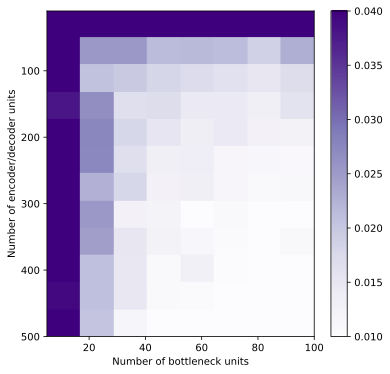

In [6]:
# show the results matrix
fig = plt.figure(figsize=(6,6))

plt.imshow(exp_results,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples', # color range and palette
           extent=[ N_bottle_units[0],N_bottle_units[-1],N_encdec_units[-1],N_encdec_units[0], ]) # xy axis ticks
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

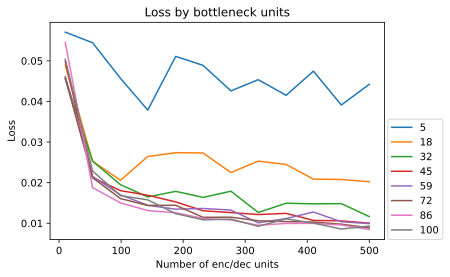

In [7]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(N_encdec_units,exp_results)
plt.legend(N_bottle_units,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

# Additional explorations

In [8]:
# 1) Because the full experiment takes a long time, it's not pratical to add another factor. Fix the number of encoder
#    units to 100 and instead parametrically explore the learning rate. You don't need so many learning rates, just use
#    [.0001, .001, .01]. The results can be shown in a line plot, with one line per lr and bottleneck units on the x-axis.
# 
# 2) Smooth transitions across parameters are easy to interpret. But the image plot shows a sharp transition for small
#    numbers of bottleneck units. This rings alarm bells for any experimental scientist! It means that something is 
#    happening at that region of parameter space and you should investigate. Thus, re-run the experiment but change the
#    parameters to focus specifically on the region of the parameter space where there are large changes in the results.
# 